In [1]:
## libraries

import os

import numpy as np
import pandas as pd

import matplotlib as mplot
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import model_selection
from sklearn import ensemble
# from matplotlib import gridspec


import warnings

from zipfile import ZipFile
import urllib.request
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')
# plt.style.use("dark_background")
pd.set_option( 'display.max_columns', 500 )

In [2]:
data = pd.read_csv( 'dataset/creditCard.csv' )

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop(columns=['Class'])
y = data['Class']

# Normalize the 'Amount' and 'Time' columns
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

X_train_res.shape, y_train_res.shape

((454902, 30), (454902,))

#### Deep Autoencoder

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 14

## encoder layers
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = Dense(int(encoding_dim / 4), activation="relu")(encoder)
## decoder layers
decoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [5]:
# Train the autoencoder
history_ae = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)
loss_ae = history_ae.history['loss']
valdLoss_ae = history_ae.history['val_loss']


Epoch 1/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 6s 944us/step - loss: 1.0610 - val_loss: 0.9984
Epoch 2/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 911us/step - loss: 0.9584 - val_loss: 0.9712
Epoch 3/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 938us/step - loss: 0.9598 - val_loss: 0.9672
Epoch 4/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 941us/step - loss: 0.9424 - val_loss: 0.9584
Epoch 5/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 933us/step - loss: 0.9412 - val_loss: 0.9544
Epoch 6/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 6s 970us/step - loss: 0.9263 - val_loss: 0.9517
Epoch 7/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 942us/step - loss: 0.9239 - val_loss: 0.9484
Epoch 8/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 898us/step - loss: 0.9236 - val_loss: 0.9459
Epoch 9/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 904us/step - loss: 0.9510 - val_loss: 0.9431
Epoch 10/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 5s 932us/step - loss: 0.9241 - val_loss: 0.9423
Epoch 11/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 6s 964us/step - loss: 0.9235 - val_loss: 0.94

In [6]:
#### anomaly detection:

# Use the autoencoder to reconstruct the test data
X_test_reconstructed = autoencoder.predict(X_test)
# Calculate the reconstruction error
mse = np.mean(np.power(X_test - X_test_reconstructed, 2), axis=1)
# Set a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # 95th percentile of the reconstruction error
# Identify anomalies
y_pred = (mse > threshold).astype(int)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step


              precision    recall  f1-score   support

    No Fraud       1.00      0.95      0.97     56864
       Fraud       0.03      0.87      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.52     56962
weighted avg       1.00      0.95      0.97     56962



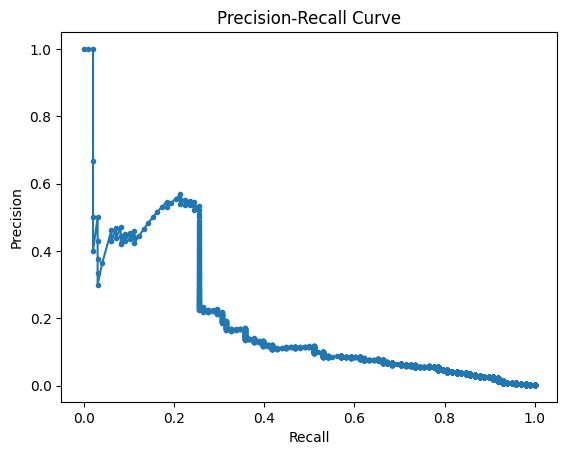

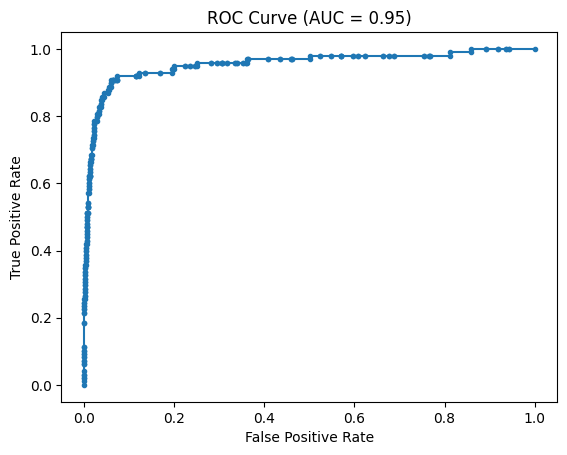

In [7]:
#### Evaluation

from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))

# Plot Precision-Recall Curve
precision_ae, recall_ae, _ = precision_recall_curve(y_test, mse)
plt.plot(recall_ae, precision_ae, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Plot ROC Curve
fpr_ae, tpr_ae, _ = roc_curve(y_test, mse)
roc_auc_ae = auc(fpr_ae, tpr_ae)
plt.plot(fpr_ae, tpr_ae, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc_ae:.2f})')
plt.show()

### LSTM

In [8]:
from keras.layers import LSTM, RepeatVector, TimeDistributed

X = data.drop(columns=['Class'])
y = data['Class']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data to 3D array for LSTM (samples, timesteps, features)
X_scaled_3d = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_3d, y, test_size=0.2, random_state=42)

# Define the LSTM autoencoder model
timesteps = X_train.shape[1]
input_dim = X_train.shape[2]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the autoencoder
history_lstm = autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

loss_lstm = history_lstm.history['loss']
valdLoss_lstm = history_lstm.history['val_loss']

Epoch 1/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.5082 - val_loss: 0.1136
Epoch 2/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0597 - val_loss: 0.0334
Epoch 3/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0267 - val_loss: 0.0418
Epoch 4/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0203 - val_loss: 0.0132
Epoch 5/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0189 - val_loss: 0.0130
Epoch 6/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0165 - val_loss: 0.0116
Epoch 7/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0171 - val_loss: 0.0148
Epoch 8/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0144 - val_loss: 0.0111
Epoch 9/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0135 - val_loss: 0.0069
Epoch 10/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0134 - val_loss: 0.0070
Epoch 11/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0144 - val_loss: 0.0272
Epoch 12

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

    No Fraud       1.00      0.95      0.97     56864
       Fraud       0.03      0.87      0.06        98

    accuracy                           0.95     56962
   macro avg       0.51      0.91      0.52     56962
weighted avg       1.00      0.95      0.97     56962



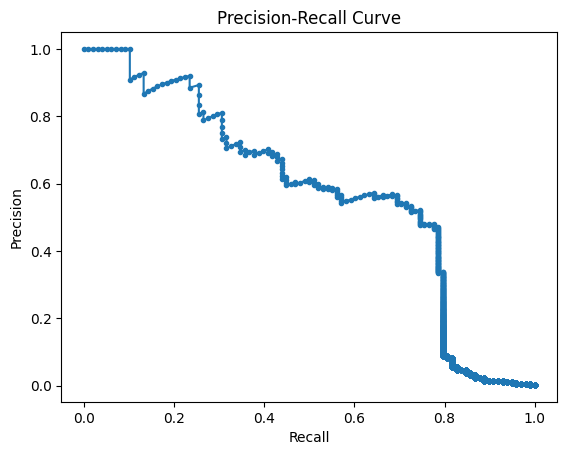

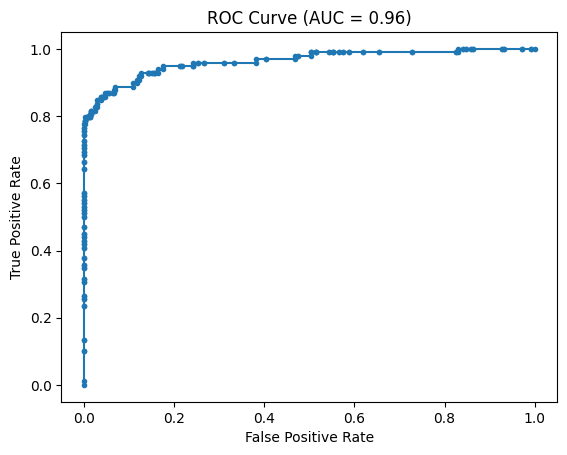

In [9]:
# Use the autoencoder to reconstruct the test data
X_test_reconstructed = autoencoder.predict(X_test)
# Reshape the reconstructed data to 2D array for error calculation
X_test_reconstructed_2d = X_test_reconstructed.reshape((X_test_reconstructed.shape[0], X_test_reconstructed.shape[2]))
# Calculate the reconstruction error
mse = np.mean(np.power(X_test.reshape((X_test.shape[0], X_test.shape[2])) - X_test_reconstructed_2d, 2), axis=1)
# Set a threshold for anomaly detectin
threshold = np.percentile(mse, 95)  # 95th percentile of the reconstruction error
# Identify anomalies
y_pred = (mse > threshold).astype(int)
# Evaluate the model
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))
# Plot Precision-Recall Curve
precision_lstm, recall_lstm, _ = precision_recall_curve(y_test, mse)
plt.plot(recall_lstm, precision_lstm, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
# Plot ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, mse)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc_lstm:.2f})')
plt.show()

#### Comparison plots

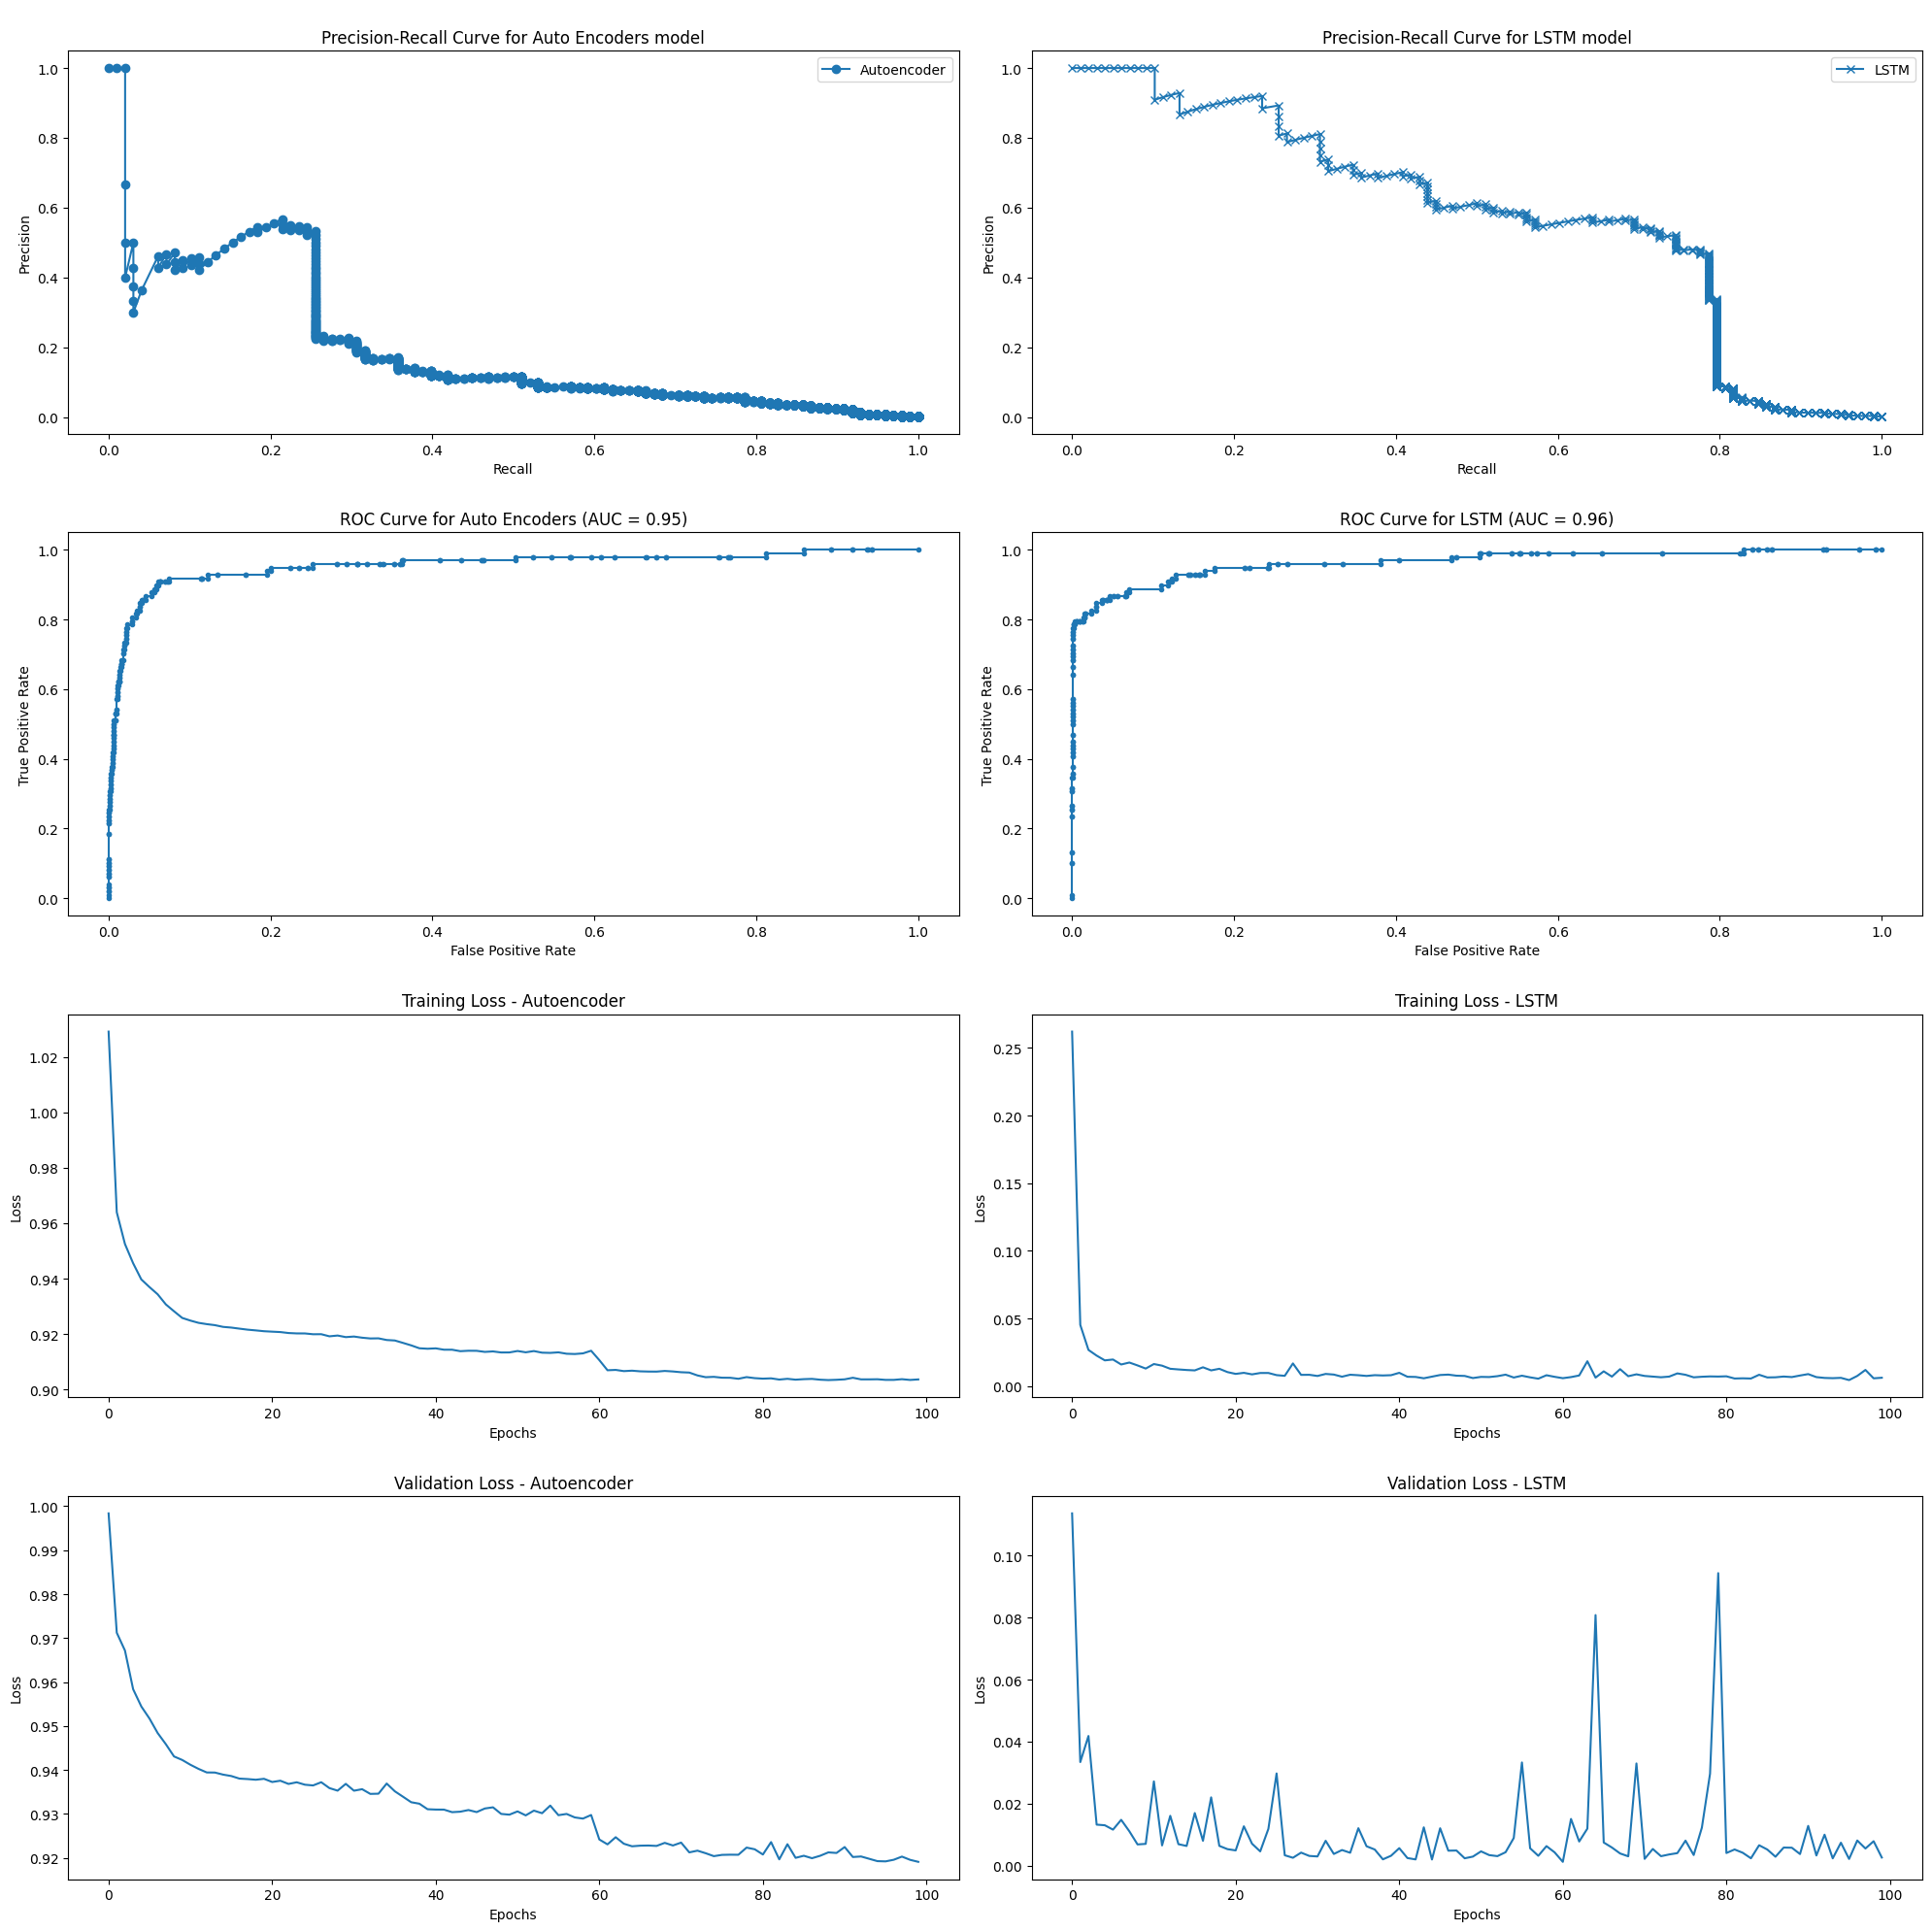

In [10]:
fg, ax = plt.subplots(  4,2, figsize= ( 20, 5*4 )  )

# Plot precision-recall curve
ax[0][0].plot(recall_ae, precision_ae, marker='o', label='Autoencoder')
ax[0][0].set_title('\nPrecision-Recall Curve for Auto Encoders model')
ax[0][0].set_xlabel('Recall') ;  ax[0][0].set_ylabel('Precision')
ax[0][0].legend(); 

ax[0][1].plot(recall_lstm, precision_lstm, marker='x', label='LSTM')
ax[0][1].set_title('\nPrecision-Recall Curve for LSTM model')
ax[0][1].set_xlabel('Recall') ;  ax[0][1].set_ylabel('Precision')
ax[0][1].legend()


### ROC Curve
ax[1][0].plot(fpr_ae, tpr_ae, marker='.')
ax[1][0].set_xlabel('False Positive Rate') ; ax[1][0].set_ylabel('True Positive Rate')
ax[1][0].set_title(f'\nROC Curve for Auto Encoders (AUC = {roc_auc_ae:.2f})')

ax[1][1].plot(fpr_lstm, tpr_lstm, marker='.')
ax[1][1].set_xlabel('False Positive Rate') ; ax[1][1].set_ylabel('True Positive Rate')
ax[1][1].set_title(f'\nROC Curve for LSTM (AUC = {roc_auc_lstm:.2f})')

## loss plot

ax[2][0].plot( loss_ae, label= 'Training Loss - Autoencoder')
ax[2][0].set_xlabel('Epochs'); ax[2][0].set_ylabel('Loss')
ax[2][0].set_title(  '\nTraining Loss - Autoencoder'  )

ax[2][1].plot( loss_lstm, label= 'Training Loss - LSTM')
ax[2][1].set_xlabel('Epochs'); ax[2][1].set_ylabel('Loss')
ax[2][1].set_title(  '\nTraining Loss - LSTM'  )


## validation loss plot

ax[3][0].plot( valdLoss_ae, label= 'Validation Loss - Autoencoder')
ax[3][0].set_xlabel('Epochs'); ax[3][0].set_ylabel('Loss')
ax[3][0].set_title(  '\nValidation Loss - Autoencoder'  )

ax[3][1].plot( valdLoss_lstm, label= 'Validation Loss - LSTM')
ax[3][1].set_xlabel('Epochs'); ax[3][1].set_ylabel('Loss')
ax[3][1].set_title(  '\nValidation Loss - LSTM'  )


plt.tight_layout(); plt.show()